In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
import os

C:\Users\user\AppData\Local\Temp\ipykernel_18176\806035556.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
train_dataset_path = "F:\\archive\\data\\puzzle_2x2\\train\\"
train_label_path = "F:\\archive\\data\\puzzle_2x2\\train_filtered.csv"

test_dataset_path = "F:\\archive\\data\\puzzle_2x2\\test\\"
test_label_path = "F:\\archive\\data\\puzzle_2x2\\test.csv"

validation_dataset_path = "F:\\archive\\data\\puzzle_2x2\\valid\\"
validation_label_path = "F:\\archive\\data\\puzzle_2x2\\valid.csv"

def load_data(dataset_path, label_path, percentage=100):
    df = pd.read_csv(label_path)
    images = []
    labels = []

    # Select a subset of data based on the percentage
    num_samples = int(len(df) * (percentage / 100))
    df = df.head(num_samples)

    for index, row in df.iterrows():
        image_name = row['image']  # Get the image name from the dataframe
        image_path = os.path.join(dataset_path, image_name)  # Construct the full image path
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100))
        image = tf.keras.preprocessing.image.img_to_array(image)
        images.append(image)

        # Convert label permutation to integer index
        label_permutation = [int(x) for x in row['label'].split()]
        label_index = get_permutation_index(label_permutation)
        
        labels.append(label_index)

    return np.array(images), np.array(labels)

def get_permutation_index(perm):
    # Define all possible permutations of [0, 1, 2, 3]
    permutations = [
        [0, 1, 2, 3], [0, 1, 3, 2], [0, 2, 1, 3], [0, 2, 3, 1],
        [0, 3, 1, 2], [0, 3, 2, 1], [1, 0, 2, 3], [1, 0, 3, 2],
        [1, 2, 0, 3], [1, 2, 3, 0], [1, 3, 0, 2], [1, 3, 2, 0],
        [2, 0, 1, 3], [2, 0, 3, 1], [2, 1, 0, 3], [2, 1, 3, 0],
        [2, 3, 0, 1], [2, 3, 1, 0], [3, 0, 1, 2], [3, 0, 2, 1],
        [3, 1, 0, 2], [3, 1, 2, 0], [3, 2, 0, 1], [3, 2, 1, 0]
    ]
    # Find the index of the given permutation in the list of permutations
    index = permutations.index(perm)
    return index


In [4]:
# Example usage:
# train_images, train_labels = load_data(train_dataset_path, train_label_path, percentage=100)
test_images, test_labels = load_data(test_dataset_path, test_label_path, percentage=100)
# validation_images, validation_labels = load_data(validation_dataset_path, validation_label_path, percentage=100)
# print(train_labels.shape)

# Normalize pixel values to be between 0 and 1
# train_images = train_images / 255.0
test_images = test_images / 255.0
# validation_images = validation_images / 255.0

In [15]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Model Checkpoint
checkpoint = ModelCheckpoint('best_2x2_VGG_model.h5', monitor='val_accuracy', save_best_only=True)

# Define the base model (VGG16) without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Learning Rate Scheduler
def lr_scheduler(epoch, lr):
    if epoch and epoch % 4 == 0:
        return lr * 0.8  # Reduce learning rate by 20% every 10 epochs
    return lr

lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Freeze the base model layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)  # L2 regularization
x = BatchNormalization()(x)  # Batch normalization
x = Dropout(0.5)(x)  # Dropout regularization
output = Dense(24, activation='softmax')(x)

# Create the final model
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model with RMSprop optimizer and categorical cross-entropy loss
model.compile(optimizer=RMSprop(learning_rate=0.001),  # RMSprop optimizer
              loss='sparse_categorical_crossentropy',  # Sparse categorical cross-entropy
              metrics=['accuracy'])

# Train the model with batch normalization, dropout, and RMSprop optimizer
history = model.fit(
    train_images, train_labels, 
    batch_size=256,
    epochs=50,
    validation_data=(validation_images, validation_labels),
    callbacks=[ early_stopping,checkpoint,lr_scheduler_callback],
    verbose=1)

# Evaluate the model on test data 
test_loss, test_acc = model.evaluate(test_images, test_labels)

# Save the final model
model.save('final_2x2_VGG_model.h5')

# Load the best model
best_model = models.load_model('best_2x2_VGG_model.h5')

# Evaluate the best model
best_model_loss, best_model_acc = best_model.evaluate(test_images, test_labels)

# Predict labels for test data
predictions = best_model.predict(test_images)
predicted_permutations = np.argmax(predictions, axis=1)  # Get the index of the highest probability for each sample

Epoch 1/50
85/85 [==============================] - 717s 8s/step - loss: 3.4826 - accuracy: 0.1501 - val_loss: 10.0769 - val_accuracy: 0.0623 - lr: 0.0010
Epoch 2/50
85/85 [==============================] - 737s 9s/step - loss: 1.9428 - accuracy: 0.4396 - val_loss: 2.7231 - val_accuracy: 0.3455 - lr: 0.0010
Epoch 3/50
85/85 [==============================] - 818s 10s/step - loss: 1.4389 - accuracy: 0.5741 - val_loss: 2.0654 - val_accuracy: 0.4312 - lr: 0.0010
Epoch 4/50
85/85 [==============================] - 730s 9s/step - loss: 1.1641 - accuracy: 0.6443 - val_loss: 2.0396 - val_accuracy: 0.4935 - lr: 0.0010
Epoch 5/50
85/85 [==============================] - 734s 9s/step - loss: 0.9047 - accuracy: 0.7198 - val_loss: 2.5241 - val_accuracy: 0.4026 - lr: 8.0000e-04
Epoch 6/50
85/85 [==============================] - 694s 8s/step - loss: 0.6991 - accuracy: 0.7822 - val_loss: 2.2654 - val_accuracy: 0.4779 - lr: 8.0000e-04
Epoch 7/50
85/85 [==============================] - 670s 8s/step -

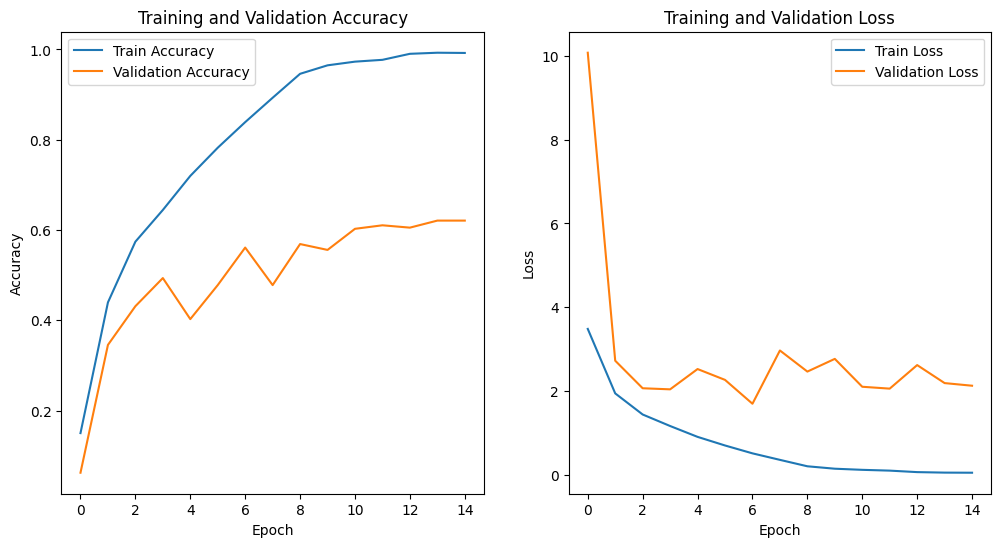

In [16]:
# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plots
plt.savefig('2x2_VGGNet_training_plots.png')

# Write final testing accuracy to a text file
with open('2x2_VGGNet_testing_accuracy.txt', 'w') as f:
    f.write('Final Test accuracy: {:.4f}\n'.format(test_acc))
    f.write('Best Model Test accuracy: {:.4f}\n'.format(best_model_acc))


1/1 [==============================] - 0s 359ms/step
Actual Label (Permutation Form): 3 0 1 2 
Predicted Label (Permutation Form): [3, 1, 0, 2]


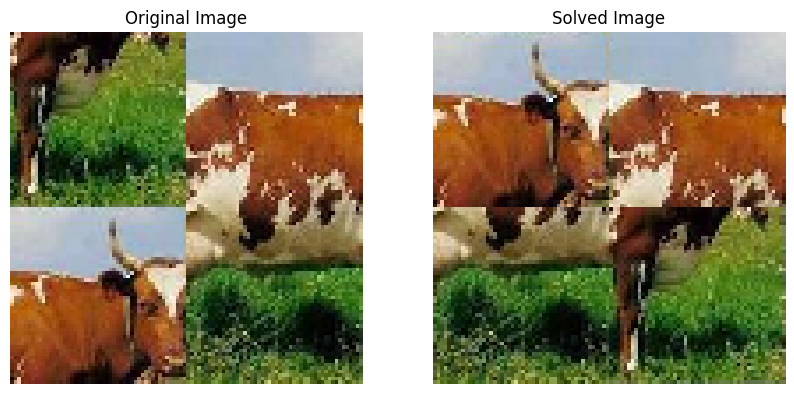

1/1 [==============================] - 0s 110ms/step
Actual Label (Permutation Form): 3 2 1 0 
Predicted Label (Permutation Form): [3, 2, 1, 0]


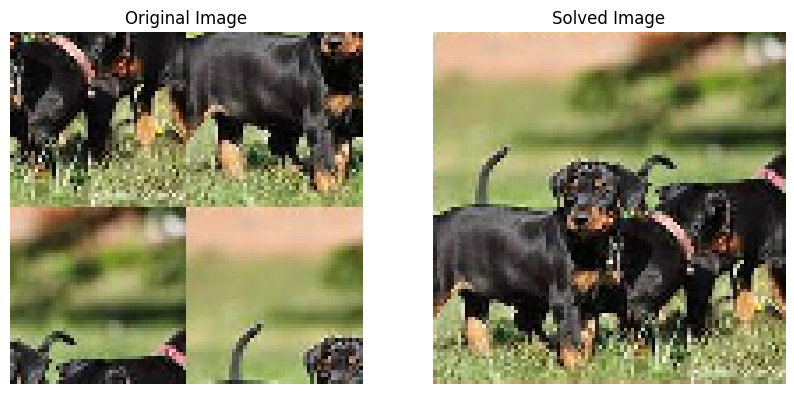

1/1 [==============================] - 0s 107ms/step
Actual Label (Permutation Form): 0 1 3 2 
Predicted Label (Permutation Form): [0, 1, 3, 2]


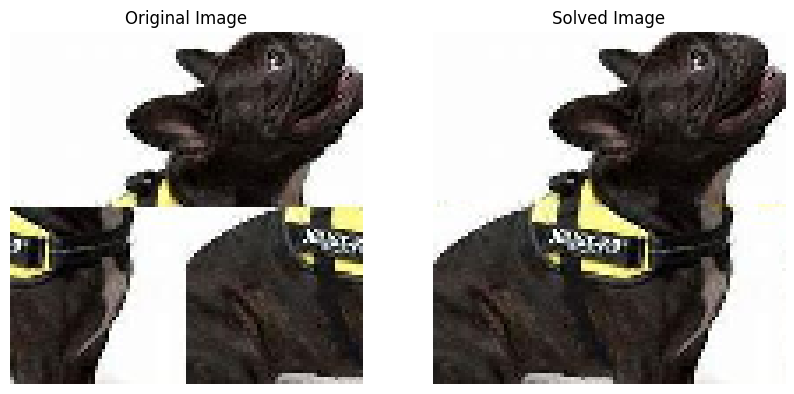

1/1 [==============================] - 0s 95ms/step
Actual Label (Permutation Form): 1 3 2 0 
Predicted Label (Permutation Form): [1, 3, 2, 0]


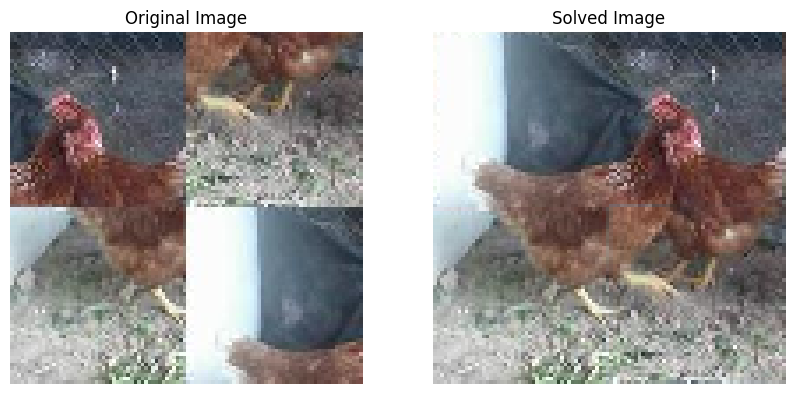

1/1 [==============================] - 0s 103ms/step
Actual Label (Permutation Form): 2 0 3 1 
Predicted Label (Permutation Form): [2, 0, 3, 1]


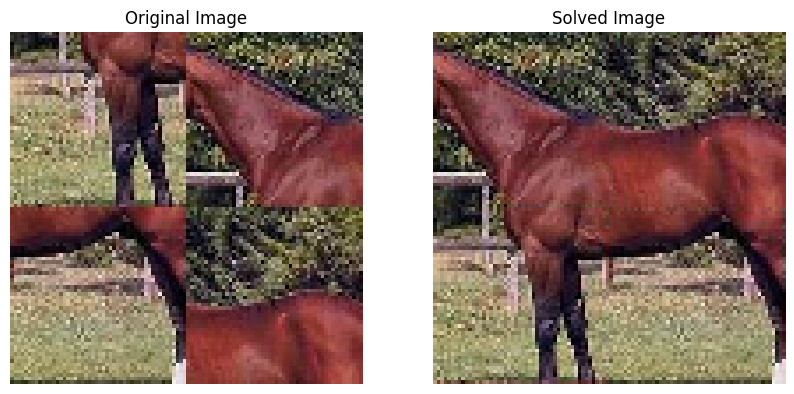

1/1 [==============================] - 0s 172ms/step
Actual Label (Permutation Form): 0 3 2 1 
Predicted Label (Permutation Form): [0, 3, 2, 1]


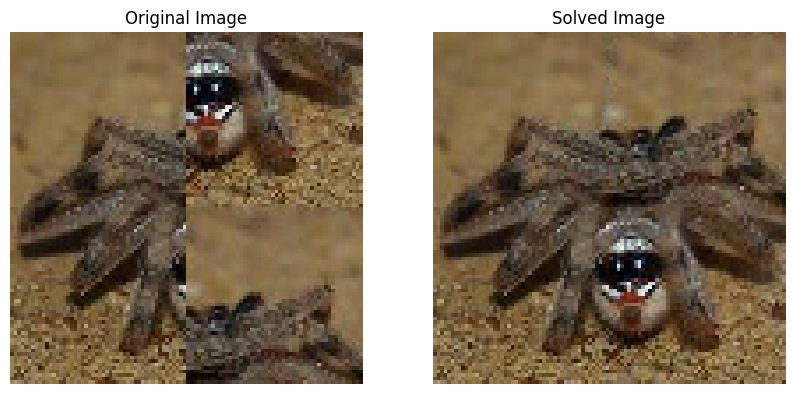

1/1 [==============================] - 0s 98ms/step
Actual Label (Permutation Form): 1 3 2 0 
Predicted Label (Permutation Form): [0, 2, 3, 1]


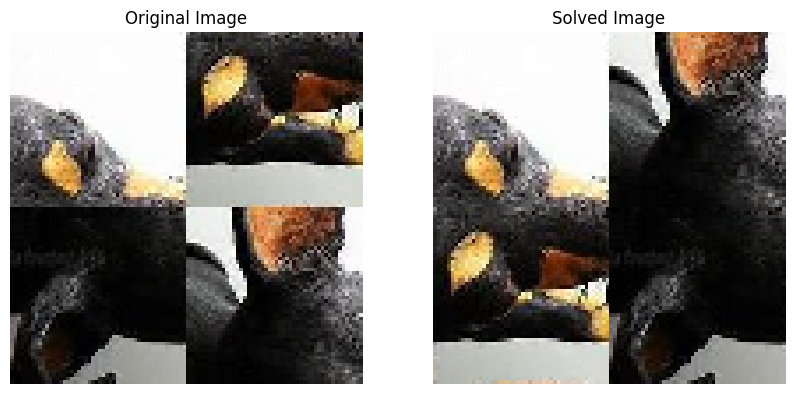

1/1 [==============================] - 0s 110ms/step
Actual Label (Permutation Form): 0 2 1 3 
Predicted Label (Permutation Form): [1, 3, 0, 2]


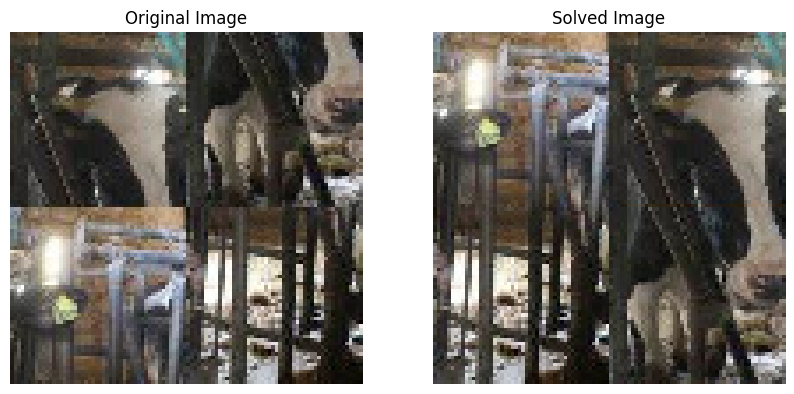

1/1 [==============================] - 0s 115ms/step
Actual Label (Permutation Form): 3 2 0 1 
Predicted Label (Permutation Form): [3, 2, 0, 1]


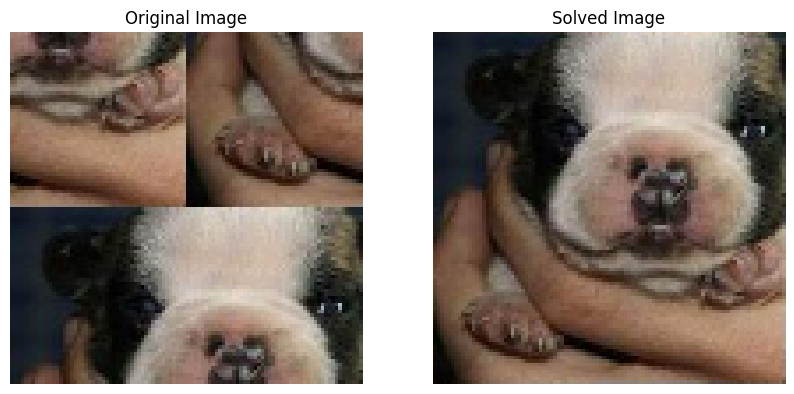

1/1 [==============================] - 0s 106ms/step
Actual Label (Permutation Form): 3 0 1 2 
Predicted Label (Permutation Form): [3, 0, 1, 2]


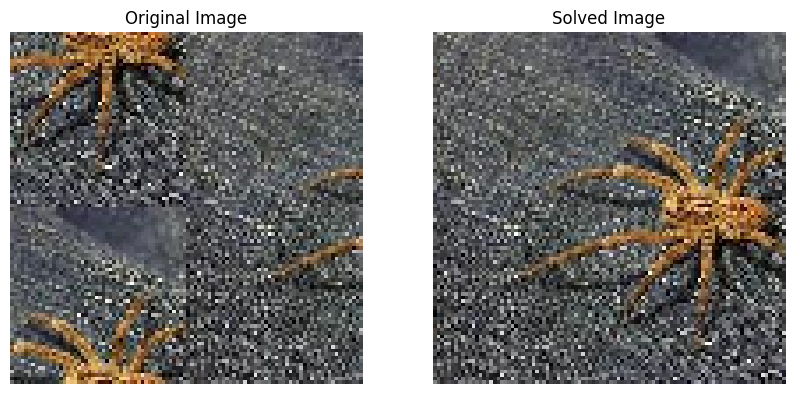

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import pandas as pd

# Load the best model
best_model = load_model('best_2x2_VGG_model.h5')

# Define the paths for testing images and labels
test_folder_path = "F:\\archive\\data\\puzzle_2x2\\test\\"
test_label_path = "F:\\archive\\data\\puzzle_2x2\\test.csv"
test_images = os.listdir(test_folder_path)[:10]  # Select the first 10 images

# Load the test labels
test_labels_df = pd.read_csv(test_label_path)

# Function to solve puzzle and display images
def solve_and_display_puzzle(model, image_path, true_label, count):
    # Load the image
    image = load_img(image_path, target_size=(100, 100))
    img_array = img_to_array(image)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values

    permutations = [
        [0, 1, 2, 3], [0, 1, 3, 2], [0, 2, 1, 3], [0, 2, 3, 1],
        [0, 3, 1, 2], [0, 3, 2, 1], [1, 0, 2, 3], [1, 0, 3, 2],
        [1, 2, 0, 3], [1, 2, 3, 0], [1, 3, 0, 2], [1, 3, 2, 0],
        [2, 0, 1, 3], [2, 0, 3, 1], [2, 1, 0, 3], [2, 1, 3, 0],
        [2, 3, 0, 1], [2, 3, 1, 0], [3, 0, 1, 2], [3, 0, 2, 1],
        [3, 1, 0, 2], [3, 1, 2, 0], [3, 2, 0, 1], [3, 2, 1, 0]
    ]

    # Predict the permutation
    predictions = model.predict(img_array)
    predicted_permutation = np.argmax(predictions)
    print("Actual Label (Permutation Form):", true_label)
    print("Predicted Label (Permutation Form):", permutations[predicted_permutation])

    # Reshape the permutation
    permutation = permutations[predicted_permutation]

    # Rearrange the image based on the predicted permutation
    solved_image = np.zeros((100, 100, 3), dtype=np.uint8)
    for i in range(2):
        for j in range(2):
            idx = permutation[i * 2 + j]  # Calculate the index from flattened permutation
            row_start = (idx // 2) * 50
            row_end = row_start + 50
            col_start = (idx % 2) * 50
            col_end = col_start + 50
            sub_image = img_array[0][i * 50:(i + 1) * 50, j * 50:(j + 1) * 50] * 255  # Denormalize the sub-image
            solved_image[row_start:row_end, col_start:col_end] = sub_image.astype(np.uint8)  # Ensure dtype is uint8
    # Display original and solved images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(solved_image)
    axes[1].set_title('Solved Image')
    axes[1].axis('off')
    plt.savefig('result_' + str(count) + '.png')
    plt.show()

# Solve and display puzzles for the first 10 images
count = 0
for image_name in test_images:
    count = count + 1
    image_path = os.path.join(test_folder_path, image_name)
    image_index = int(image_name.split('.')[0])  # Extract the image index from the filename
    true_label = test_labels_df.loc[image_index, 'label']  # Get the true label from the dataframe
    solve_and_display_puzzle(best_model, image_path, true_label, count)
